In [72]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import tdgl
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D

# Initialize some experimental parameters

In [54]:
thickness = 0.1 #um
london_lambda = 128.48 * 1e-3 # 0.12848 um, the value that was used in simulations
junction_length = 0.110 #um, 120 by design, 100-110 in real device.

# Grab the files that we are going to analyze (N=0 for now)

In [6]:
project_name = "J7_antidot"
no_screening_folder = os.getcwd() + "/solutions/" + project_name + "/no_screening/"
stable_no_screening_folder = os.getcwd() + "/solutions/" + project_name + "/stable_no_screening/"
screening_folder = os.getcwd() + "/solutions/" + project_name + "/no_screening/"
stable_screening_folder    = os.getcwd() + "/solutions/" + project_name + "/stable_screening/"

screening_files = os.listdir(stable_screening_folder)

simulation_points = []
for file_name in screening_files:
    file_pattern = r'field_([-+]?\d*\.\d+|\d+)_vortex_([-+]?\d+)'
    match = re.search(file_pattern, file_name)
    if match:
        field_strength = float(match.group(1))
        initial_vortex_count = int(match.group(2))
        simulation_points.append((file_name, field_strength, initial_vortex_count))
    else:
        print("WARNING: Corrupt filenames present in ./solutions/no_screening")

# Define functions to calculate the currents along the edges of the devices

In [52]:
def calculate_edge_current(solution, thickness):
    # This function calculates the current density along the bottom edge of a rectangular device
    # It accomplishes this by running a short line segment along the bottom edge (path_length) and 
    # measuring the current through the line segment. It then divides by the cross sectional area
    # to get the current density

    x_min = min(solution.device.points[:, 0])
    x_max = max(solution.device.points[:, 0])
    y_min = min(solution.device.points[:, 1])
    y_max = max(solution.device.points[:, 1])
    
    x_list = np.linspace(x_min, x_max, 100)
    
    #Create a path at x=x_i, around the bottom edge of the device
    path_length = 0.005 #Distance over which the current is averaged
    points_count = 401

    # Calculate current through path, divide by path length, divide by device thickness, yields current density.
    current_density = [solution.current_through_path(
                np.array([x_i * np.ones(points_count), np.linspace(y_min-0.001, y_min+path_length, points_count)]).T)/(path_length*1e-6)/thickness
               for x_i in x_list]
    
    # Convert to A/m^2
    ureg = solution.device.ureg
    current_density = [(current.to(ureg.ampere)).magnitude for current in current_density]  #Actually A/m^2
    
    return x_list, current_density

def plot_edge_currents(x, currents):
    plt.plot(x, currents)
    plt.title("Edge Current")
    plt.xlabel("X_coordinate [um]")
    plt.ylabel("edge_current_density [A/m^2]")
    plt.show()
    
def plot_currents(solution):
   # Plot segment
    fig, axes = plt.subplots(1, 2, figsize=(6, 4))
    _ = solution.plot_currents(ax=axes[0], streamplot=False)
    _ = solution.plot_currents(ax=axes[1])
    plt.show()

# Define functions to calculate the guage invariant phase

In [55]:
def calculate_x_phase(x, currents, field_strength):
    #Field strength is given in mT. X is given in m, current is given in A/m^2
    global london_lambda, junction_length # junction length, london_lambda given in um, london_lamb
    phi0 = 2.067833848e-15 #Wb
    u0 = 1.256637*1e-6 #N*A**(-2)
    eta = (2*np.pi/phi0) * ((london_lambda*1e-6)**2*u0) #Constant in units of m/A
    x_phase = [(-2*eta*current + 2*np.pi*field_strength*(1e-3)*junction_length*1e-6/phi0)*x_i for (current, x_i) in zip(currents, x)]
    return x_phase
    
def plot_x_phase(x, x_phase):
    plt.plot(x, x_phase)
    plt.title("Guage Invariant Phase (Pre-Optimization)")
    plt.ylabel("Phase")
    plt.xlabel("X_coordinate [um]")
    plt.show()
    
def plot_psi(solution, show = True):
    fig, axes = solution.plot_order_parameter(figsize=(5.5, 4))
    if(show):
        plt.show()
        
    return fig, axes

In [83]:
interpolators = {}
for vortex_count_to_simulate in np.unique([point[2] for point in simulation_points]):
    x_known = [] #This will be replaced by calculate_edge_current. It won't be filled
    b_known = []
    phase_known = []
    single_vortex_list = sorted([point for point in simulation_points if point[2] == vortex_count_to_simulate], key=lambda point: (point[1]))
    for sim_point in single_vortex_list:
        try:
            b_known.append(sim_point[1])
            solution = tdgl.Solution.from_hdf5(stable_screening_folder + sim_point[0])
            print(sim_point[0])
            x_known, currents = calculate_edge_current(solution, thickness*1e-6)
            x_phase = calculate_x_phase(x_list, currents, sim_point[1])
            phase_known.append(x_phase)
        except Exception as e:
            print(e)
    b_known = np.array(b_known)
    x_known = np.array(x_known)
    phase_known = np.array(phase_known)

    interpolators[vortex_count_to_simulate] = RegularGridInterpolator((b_known, x_known), phase_known)

    # Example use of interpolator
    # print(f"B:{min(b_known)}->{max(b_known)}")
    # print(f"X:{min(x_known)}->{max(x_known)}")

    # print(interpolator((-0.5, -0.5)))



field_-14.696869067847729_vortex_-7.h5
field_-14.47085006848762_vortex_-7.h5
field_-14.244831069127509_vortex_-7.h5
field_-14.0188120697674_vortex_-7.h5
field_-13.79279307040729_vortex_-7.h5
field_-13.566774071047181_vortex_-7.h5
field_-13.34075507168707_vortex_-7.h5
field_-13.114736072326961_vortex_-7.h5
field_-12.888717072966852_vortex_-7.h5
field_-12.662698073606741_vortex_-7.h5
field_-12.436679074246632_vortex_-7.h5
field_-12.210660074886523_vortex_-7.h5
field_-11.984641075526413_vortex_-7.h5
field_-11.758622076166304_vortex_-7.h5
field_-11.532603076806193_vortex_-7.h5
field_-11.306584077446084_vortex_-7.h5
field_-11.080565078085975_vortex_-7.h5
field_-10.854546078725864_vortex_-7.h5
field_-10.402508080005646_vortex_-7.h5
field_-14.326884803411208_vortex_-6.h5
field_-13.968525307351037_vortex_-6.h5
field_-13.610165811290866_vortex_-6.h5
field_-13.251806315230695_vortex_-6.h5
field_-12.893446819170524_vortex_-6.h5
field_-12.535087323110353_vortex_-6.h5
field_-12.176727827050184_vort

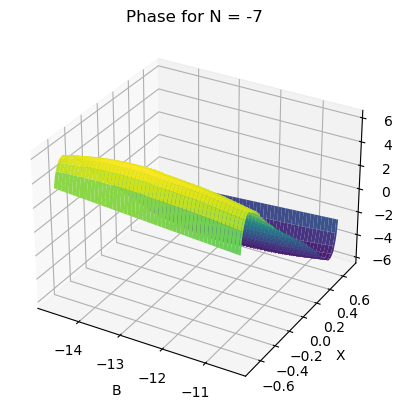

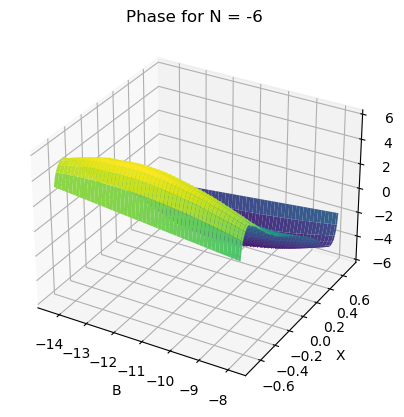

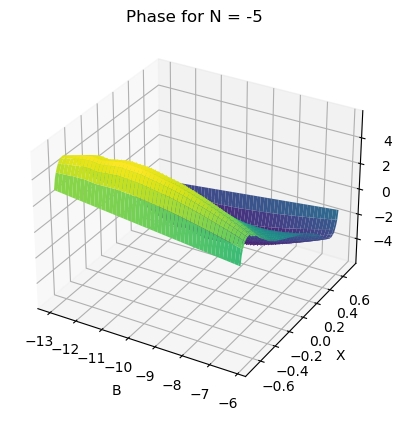

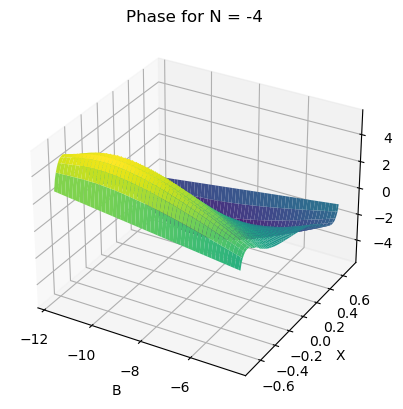

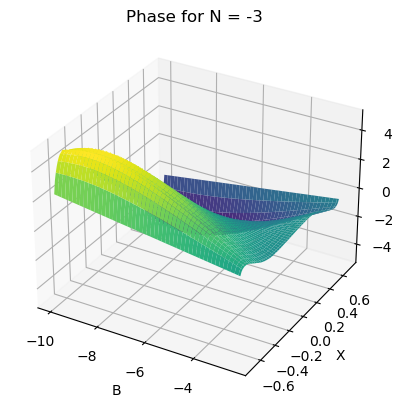

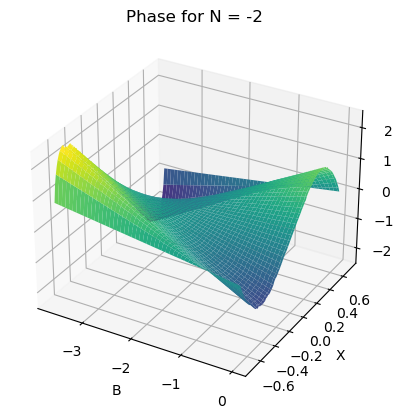

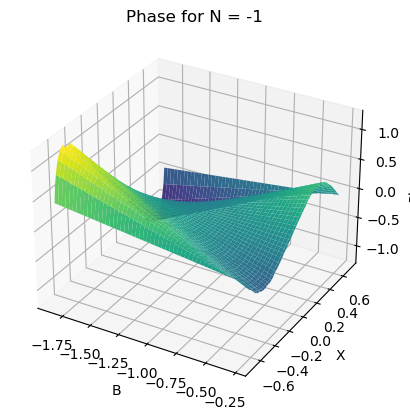

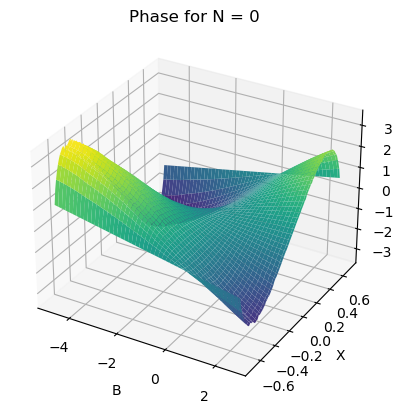

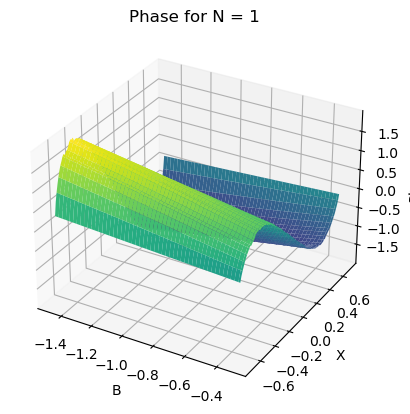

In [87]:
# Create a mesh grid for b_known and x_known
for interpolator_key in interpolators.keys():
    interpolator = interpolators[interpolator_key]

    b_min, b_max = interpolator.grid[0][0], interpolator.grid[0][-1]
    x_min, x_max = interpolator.grid[1][0], interpolator.grid[1][-1]
    b_grid, x_grid = np.meshgrid(
        np.linspace(b_min, b_max, 100), 
        np.linspace(x_min, x_max, 100)
    )

    # Flatten the grid to pass to the interpolator
    points = np.array([b_grid.flatten(), x_grid.flatten()]).T

    # Evaluate the interpolator at each point in the mesh grid
    phase_grid = interpolator(points).reshape(b_grid.shape)

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(b_grid, x_grid, phase_grid, cmap='viridis')

    # Set labels
    ax.set_xlabel('B')
    ax.set_ylabel('X')
    ax.set_zlabel('Phase')
    ax.set_title(f"Phase for N = {interpolator_key}")

    plt.show()

In [93]:
# I think some conversion factors are off, but interpolators should calculate the guage invariant phase at a given (N,B,x)

N=-1
B=-0.5
x=0.7
print(interpolators[N]((B,x)))

-116983.59351278705
